## Building a Filterbank Kernel Model

This notebook is based on the [MNE example](https://mne.tools/dev/auto_examples/decoding/decoding_csp_eeg.html) and illustrates the construction of the filterbank models.

First we load the data as in the original example.

The model here implements the Log-Euclid Kernel model from [Bonet, Malézieux et al 2023, page 7](https://arxiv.org/abs/2303.05798):

$$K^{log}_{i,j} = e^{-\frac{1}{2\sigma^2}||\log C_i - \log C_j ||^2_F}$$


Rather than assuming a one set of hyper parameters for the Gaussian Kernel accross all frequencies, here we will tune the hyperparameters independently.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit, cross_val_score

import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci

from coffeine import compute_coffeine, make_filter_bank_transformer

In [3]:
mne.set_log_level('critical')

In [4]:
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names

In [5]:
# Apply band-pass filter
raw.filter(4.0, 35.0, fir_design="firwin", skip_by_annotation="edge")

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)

labels = epochs.events[:, -1] - 2
conditions = ['feet', 'hand']

## Building a coffeine data frame of covariances per frequency


In the following, we compute covariances based on pre-defined frequencies and show how to make a coffeine data frame from them. This was previously complicated, now coffeine provides the API for it.

As this is event-related data and not subject-level data as in [Sabbagh et al 2020](https://www.sciencedirect.com/science/article/pii/S1053811920303797), we need to loop over epochs. Luckily, coffeine does this for us. We now get the pandas data frame where each columns is an object array of covariances, which is represented as a list of covariances, leading to an object array type.

In [6]:
X_df, feature_info = compute_coffeine(epochs, frequencies=('ipeg', ['alpha1', 'alpha2']))
X_df.head()

,alpha1,alpha2
0,"[[9.899550941533323e-11, 1.0150193223596802e-1...","[[1.0496460732612292e-10, 1.182282705492182e-1..."
1,"[[9.709858344182261e-11, 8.928610694895676e-11...","[[9.006992581133795e-11, 8.001210027471314e-11..."
2,"[[1.6005797216165005e-10, 1.7120265854899606e-...","[[1.2931611036887622e-10, 1.4271783164176122e-..."
3,"[[1.0282494751586464e-10, 1.0768228603843814e-...","[[1.7453066588408227e-10, 2.1678207719155818e-..."
4,"[[2.029473693821182e-10, 2.0201658837032425e-1...","[[1.955097750980857e-10, 1.9793252865855997e-1..."


Now we can call the model constructor and select our preferred covariance vectorizer, which is the Riemannian tangent-space embedding.
As this makes the assumption of full-rank data, it can be worthwhile to inspect the rank of the data.
As we will see, a rank of 64 seems to be a safe assumption althought it could also be ~60 if on some epochs the rank is lower.
If the rank of covariance is different, it makes sense to take the smallest common rank.

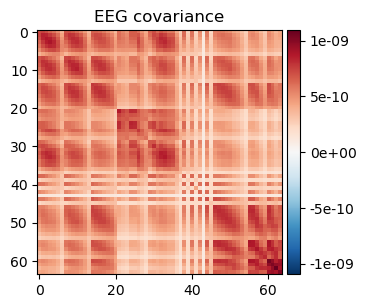

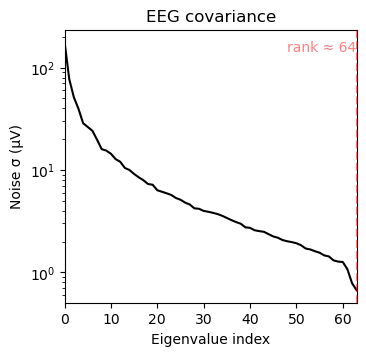

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [7]:
mne.compute_covariance(epochs).plot(epochs.info)

In [8]:
filter_bank_transformer = make_filter_bank_transformer(
    names=list(X_df.columns),
    method='riemann',
    kernel='gaussian',
    vectorization_params=dict(metric='logeuclid'),
    projection_params=dict(scale=1, n_compo=60)
)

In [9]:
filter_bank_transformer 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('projcommonspace',
                                                                   ProjCommonSpace(n_compo=60,
                                                                                   reg=1e-05,
                                                                                   scale=1)),
                                                                  ('riemann',
                                                                   Riemann(metric='logeuclid')),
                                                                  ('gaussiankernel',
                                                                   GaussianKernel())]),
                                                  'alpha1'),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('projcommonspace',
                                                                   ProjCommonSpace(n_compo=60,
                                                                                   reg=1e-05,
                                                                                   scale=1)),
                                                                  ('riemann',
                                                                   Riemann(metric='logeuclid')),
                                                                  ('gaussiankernel',
                                                                   GaussianKernel())]),
                                                  'alpha2')])),
                ('kernelsum', KernelSum())])

In [10]:
Xt_ = filter_bank_transformer.fit_transform(X_df)

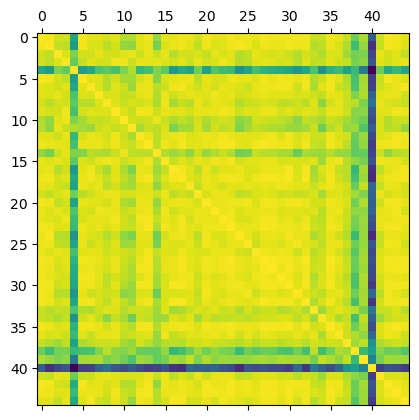

In [11]:
plt.matshow(Xt_.reshape(len(Xt_), -1, len(Xt_)).sum(1))

In [12]:
pipeline_kernel = make_pipeline(
    filter_bank_transformer,
    KernelRidge(alpha=1e-10, kernel='precomputed')
)

In [13]:
pipeline_kernel

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pipeline-1',
                                                                   Pipeline(steps=[('projcommonspace',
                                                                                    ProjCommonSpace(n_compo=60,
                                                                                                    reg=1e-05,
                                                                                                    scale=1)),
                                                                                   ('riemann',
                                                                                    Riemann(metric='logeuclid')),
                                                                                   ('gaussiankernel',
                                                                                    GaussianKernel())]),
                                                                   'alpha1'),
                                                                  ('pipeline-2',
                                                                   Pipeline(steps=[('projcommonspace',
                                                                                    ProjCommonSpace(n_compo=60,
                                                                                                    reg=1e-05,
                                                                                                    scale=1)),
                                                                                   ('riemann',
                                                                                    Riemann(metric='logeuclid')),
                                                                                   ('gaussiankernel',
                                                                                    GaussianKernel())]),
                                                                   'alpha2')])),
                                 ('kernelsum', KernelSum())])),
                ('kernelridge',
                 KernelRidge(alpha=1e-10, kernel='precomputed'))])

In [14]:
y = epochs.events[:, 2]

In [15]:
model = GridSearchCV(
    pipeline_kernel,
    param_grid={
        "pipeline__columntransformer__pipeline-1__gaussiankernel__sigma": np.logspace(0, 2, 3),
        "pipeline__columntransformer__pipeline-2__gaussiankernel__sigma": np.logspace(0, 2, 3),
    },
    scoring='roc_auc',
    n_jobs=2,
    error_score="raise"
)

model.fit(X_df, y)

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('columntransformer',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('pipeline-1',
                                                                                          Pipeline(steps=[('projcommonspace',
                                                                                                           ProjCommonSpace(n_compo=60,
                                                                                                                           reg=1e-05,
                                                                                                                           scale=1)),
                                                                                                          ('riemann',
                                                                                                           Riemann(metric='logeuclid')),
                                                                                                          ('gaussiankernel',
                                                                                                           GaussianKernel())]),
                                                                                          'alpha1'),
                                                                                         ('...
                                                                                                          ('gaussiankernel',
                                                                                                           GaussianKernel())]),
                                                                                          'alpha2')])),
                                                        ('kernelsum',
                                                         KernelSum())])),
                                       ('kernelridge',
                                        KernelRidge(alpha=1e-10,
                                                    kernel='precomputed'))]),
             n_jobs=2,
             param_grid={'pipeline__columntransformer__pipeline-1__gaussiankernel__sigma': array([  1.,  10., 100.]),
                         'pipeline__columntransformer__pipeline-2__gaussiankernel__sigma': array([  1.,  10., 100.])},
             scoring='roc_auc')

In [16]:
cv = ShuffleSplit(5, test_size=0.2, random_state=42)

In [ ]:
scores = cross_val_score(estimator=model, X=X_df, y=y, cv=cv, n_jobs=2)

In [ ]:
print(f'Mean classification accuracy: {np.mean(scores):0.2f}')

In [ ]:
model.best_params_